### Document extraction

This notebook's purpose is to make an in-depth exploration on the best ways to extract information regarding OpenCV. During the first exploratory notebook, documents were extracted from OpenCV's documentation using a recursive URL loader. One of the main challenges of this RAG is to make information Python-specific, which might be difficult given that OpenCV is written in C++, with `opencv-python` being the library available as a wrapper with bindings for Python. Most of the solutions to overcome this challenge may come in the preprocessing and prompt engineering sections of this RAG, but an exploratory task is done during this extraction phase in order to include relevant metadata that may ignore C++-centric code and documentation. Taking this issue into account, in addition to the initial exploration made in the [ExploringOpenCV](/../Notebooks/ExploringOpenCV.ipynb) notebook, this notebook has the following goals:

1. Further explore the best way to extract information from OpenCV's documentation.
    1. Explore different values for the most relevant `RecursiveUrlLoader`'s parameters. Analyze document number vs extraction velocity.
    2. Explore the effectiveness of using multiple loaders instead of a single one, starting from more specific root URLs.
    3. For each new extraction idea, compare URL title with [OpenCV Documentation's index](https://docs.opencv.org/4.x/index.html), in order to identify relevance.
    4. Record and analyze failed or slow requests, to better refine parameters in `RecursiveUrlLoader`. 
2. Find new sources for information regarding OpenCV's features.
    1. Extract information from [LearnOpenCV](https://learnopencv.com). Specially, from its three main guides: 
        - [Getting Started with OpenCV](https://learnopencv.com/getting-started-with-opencv/)
        - [Getting Started with PyTorch](https://learnopencv.com/getting-started-with-pytorch/)
        - [Getting Started with Keras & Tensorflow](https://learnopencv.com/getting-started-with-tensorflow-keras/)
    In this case, `RecursiveUrlLoader` might not be the best idea. Instead, an initial approach will be to have a tutorial list for each guide, which is easily accessible.
    2. Explore the usefulness of including [FreeCodeCamp's OpenCV Course](https://www.youtube.com/watch?v=oXlwWbU8l2o) as part of the knowledge base. This would require a transcript of the video, which might be computationally expensive and there's risk of inaccuracies.
3. Create a relevance measurement for each created loader. This tool would compare each document's title and summary to a base document (to be defined) and flag possible irrelevant documents. This step is important for two main concerns regarding data extraction:
    - `RecursiveUrlLoader` may extract documents that are not relevant to a person looking for documentation, such as a contact page.
    - Some documents might be too C++-oriented, such as the use of CMake to install OpenCV. These should be discarded.
4. For each document in each loader, extract relevant metadata that might indicate that the content is not relevant for Python, so that it can be pre-processed in a later stage and converted to the Python equivalent if needed.
5. Measure performance indicators for each loader, such as extraction speed, completeness and failures, which will be the final judge regarding the loaders to include in the final version. 


Let's start by setting up relevant environment variables. In this particular case, it is important to set `USER_AGENT` while web scrapping in order to avoid being blocked during extraction.

In [4]:
from dotenv import load_dotenv
import os
load_dotenv()
user_agent = os.getenv("USER_AGENT", "DefaultUserAgent")
print(user_agent)

Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:132.0) Gecko/20100101 Firefox/132.0


First, we will focus on exploring the most relevant parameters of `RecursiveUrlLoader`. Besides the `url`, `extractor` and `prevent_outside`, which will not be changed for the purpose of this exploration, we will focus on two parameters that are going to be changed:
- `max_depth`
- `timeout`

We will also register the logs of the extraction process to identify extraction time, document count and possible errors. First, we set up needed imports, logging and parameters to be adjusted, in addition to the `BeautifulSoup` extractor used, which makes the extracted documents human- and LLM-friendly.

In [5]:
import logging
import os
import re
from bs4 import BeautifulSoup

# Configure logging
logging.basicConfig(filename="loader_experiment.log", level=logging.INFO, 
                    format="%(asctime)s - %(levelname)s - %(message)s")

# Directory to save extracted documents
os.makedirs("../data/ExtractedDocuments", exist_ok=True)

# Set up parameter combinations to test
depth_values = [1, 2, 3, 5, 7]
timeout_values = [2, 5, 10, 15]


def bs4_extractor(html: str) -> str:
    soup = BeautifulSoup(html, "lxml")
    return re.sub(r"\n\n+", "\n\n", soup.text).strip()


We will then extract all the documents using `RecursiveUrlLoader`. The extracted documents will be saved in the `/data/ExtractedDocuments` path of the project as JSON files. This is a lengthy process, given the recursive nature of the algorithm, so run it at your own risk. It took ~3 hours to run for me. Finally, the extraction results will be saved as a JSON file.

In [ ]:
import time
import json
from datetime import datetime
from langchain.document_loaders import RecursiveUrlLoader
from requests.exceptions import RequestException

# Store results for analysis
results = []

# Run the parameter tests and save documents
for depth in depth_values:
    for timeout in timeout_values:
        loader = RecursiveUrlLoader(
            "https://docs.opencv.org/4.x/",
            headers={"User-Agent": user_agent},
            extractor=bs4_extractor,
            max_depth=depth,
            timeout=timeout
        )
        
        start_time = time.time()
        try:
            # Extract documents
            documents = loader.load()
            duration = time.time() - start_time
            doc_count = len(documents)
            # Save documents to a JSON file
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"../data/ExtractedDocuments/docs_depth{depth}_timeout{timeout}_{timestamp}.json"
            with open(filename, "w") as file:
                for doc in documents:
                    file.write(doc.json()+'\n')
            logging.info(
                f"Depth={depth}, Timeout={timeout}: "
                f"Extracted {doc_count} documents in {duration:.2f} seconds."
            )
            result = {
                "max_depth": depth,
                "timeout": timeout,
                "doc_count": doc_count,
                "duration": duration,
                "file": filename
            }
            results.append(result)
            print(result)
            
        except RequestException as e:
            logging.error(
                f"Depth={depth}, Timeout={timeout}: "
                f"Failed with error {str(e)}"
            )
        except Exception as e:
            logging.error(
                f"Depth={depth}, Timeout={timeout}: "
                f"Encountered unexpected error {str(e)}"
            )

# Print and save summary of results
print("Experiment Results:")
for result in results:
    print(f"Depth={result['max_depth']}, Timeout={result['timeout']}"
          f"-> {result['doc_count']} documents in {result['duration']:.2f}s, saved to {result['file']}")

# Optionally save the results summary to a JSON file
summary_filename = "extraction_results_summary.json"
with open(summary_filename, "w") as summary_file:
    json.dump(results, summary_file)
print(f"\nSummary saved to {summary_filename}")

1
{'max_depth': 1, 'timeout': 2, 'doc_count': 1, 'duration': 0.33954763412475586, 'file': '../data/ExtractedDocuments/docs_depth1_timeout2_20241112_130610.json'}
1
{'max_depth': 1, 'timeout': 5, 'doc_count': 1, 'duration': 0.29752612113952637, 'file': '../data/ExtractedDocuments/docs_depth1_timeout5_20241112_130610.json'}
1
{'max_depth': 1, 'timeout': 10, 'doc_count': 1, 'duration': 0.4655568599700928, 'file': '../data/ExtractedDocuments/docs_depth1_timeout10_20241112_130610.json'}
1
{'max_depth': 1, 'timeout': 15, 'doc_count': 1, 'duration': 0.45436692237854004, 'file': '../data/ExtractedDocuments/docs_depth1_timeout15_20241112_130611.json'}
81
{'max_depth': 2, 'timeout': 2, 'doc_count': 81, 'duration': 44.66263556480408, 'file': '../data/ExtractedDocuments/docs_depth2_timeout2_20241112_130655.json'}
81
{'max_depth': 2, 'timeout': 5, 'doc_count': 81, 'duration': 41.8696403503418, 'file': '../data/ExtractedDocuments/docs_depth2_timeout5_20241112_130737.json'}
81
{'max_depth': 2, 'timeo

/tmp/ipykernel_34612/904634524.py:19: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  soup = BeautifulSoup(html, "lxml")
/usr/lib/python3.12/html/parser.py:171: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)


3067
{'max_depth': 7, 'timeout': 2, 'doc_count': 3067, 'duration': 1174.5577120780945, 'file': '../data/ExtractedDocuments/docs_depth7_timeout2_20241112_150054.json'}
3067
{'max_depth': 7, 'timeout': 5, 'doc_count': 3067, 'duration': 1167.2603085041046, 'file': '../data/ExtractedDocuments/docs_depth7_timeout5_20241112_152022.json'}
3065
{'max_depth': 7, 'timeout': 10, 'doc_count': 3065, 'duration': 1203.1527228355408, 'file': '../data/ExtractedDocuments/docs_depth7_timeout10_20241112_154025.json'}
3067
{'max_depth': 7, 'timeout': 15, 'doc_count': 3067, 'duration': 1164.0093593597412, 'file': '../data/ExtractedDocuments/docs_depth7_timeout15_20241112_155949.json'}
Experiment Results:
Depth=1, Timeout=2-> 1 documents in 0.34s, saved to ../data/ExtractedDocuments/docs_depth1_timeout2_20241112_130610.json
Depth=1, Timeout=5-> 1 documents in 0.30s, saved to ../data/ExtractedDocuments/docs_depth1_timeout5_20241112_130610.json
Depth=1, Timeout=10-> 1 documents in 0.47s, saved to ../data/Extra

Now, we can make a basic quantitative analysis by using the `extraction_results_summary.json`file. This will allow us to check how relevant are the two parameters that we modified. Later, we'll use the extracted documents for a more in-depth analysis. First, we load the generated JSON file for extraction results:

In [ ]:
from  langchain.schema import Document
import json
from glob import glob

summary_files = glob("extraction_results_summary.json")
summary_data = []
for file in summary_files:
    with open(file, "r") as f:
        summary_data.extend(json.load(f))



We can generate some interesting plots that may tell us more about each iteration's duration and size. Let's start with a simple correlation matrix between all the variables we have at our disposal.

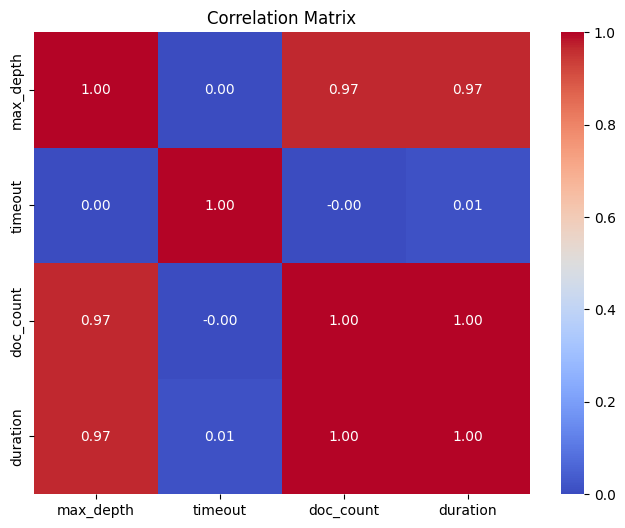

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load JSON summary into a DataFrame
summary_df = pd.DataFrame(summary_data)

# Correlation heatmap between parameters and key metrics
correlation_matrix = summary_df[['max_depth', 'timeout', 'doc_count', 'duration']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


There are some key aspects to retrieve from this matrix:
- As expected, there is a very high (perfect) correlation between the `doc_count` and `duration`, which could mean that document length isn't as important to determine extraction duration. This is to be confirmed later through the use of the extracted documents. 
- It makes sense that `max_depth` also has a high correlation both with `doc_count` and `duration`, as a more in-depth search means a higher number of documents. 
- There is almost no correlation between `timeout` and the other variables, indicating that the `timeout` settings do not strongly influence the document count or extraction time in these cases. The hope was that, by reducing the `timeout`, the extraction time would be reduced. However, by checking the `loader_experiment.log`, only 1 timeout error occurred in the whole experiment, making the change in the value of this parameter useless. However, the experiment helped to show that a 2 second `timeout` is enough and any greater value is not needed.


Now, lets focus a bit more in the `max_depth` parameter, to better understand how it relates to other variables. While there isn't much that can be analyzed without checking the document relevance, we can check for patterns between `max_depth` and `doc_count`.

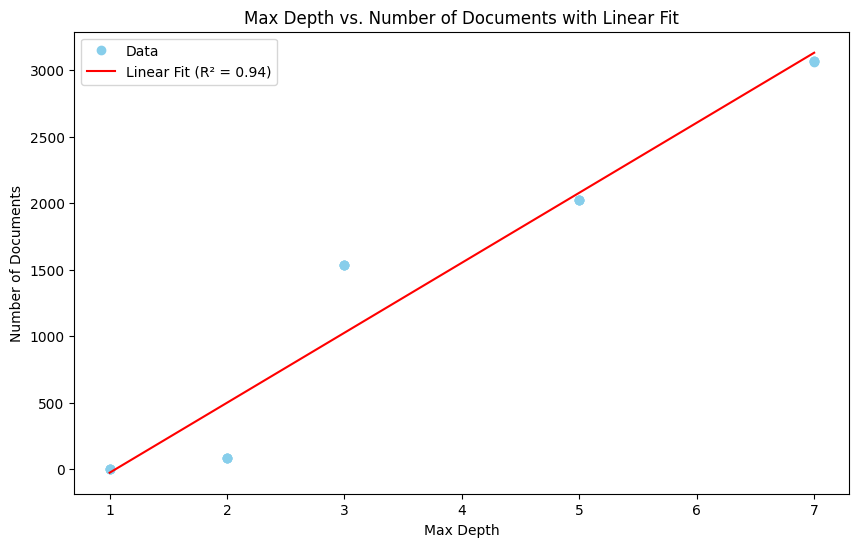

In [11]:
import matplotlib.pyplot as plt
import numpy as np

max_depths = [result['max_depth'] for result in summary_data]
doc_counts = [result['doc_count'] for result in summary_data]

# Convert to numpy arrays for easier manipulation
max_depths = np.array(max_depths)
doc_counts = np.array(doc_counts)

# Fit a linear regression line to the data
slope, intercept = np.polyfit(max_depths, doc_counts, 1)  # 1st degree polynomial (linear)
linear_fit = slope * max_depths + intercept

# Calculate R²
correlation_matrix = np.corrcoef(max_depths, doc_counts)
correlation_xy = correlation_matrix[0, 1]
r_squared = correlation_xy**2

# Plot data and linear fit
plt.figure(figsize=(10, 6))
plt.plot(max_depths, doc_counts, 'o', label='Data', color='skyblue')  # Scatter plot of data points
plt.plot(max_depths, linear_fit, 'r-', label=f'Linear Fit (R² = {r_squared:.2f})')  # Linear fit line

# Add labels and title
plt.xlabel('Max Depth')
plt.ylabel('Number of Documents')
plt.title('Max Depth vs. Number of Documents with Linear Fit')
plt.legend()

# Show the plot
plt.show()


Data seems to follow a linear tendency, with an R² of 0.94. However, given the small size of our dataset, the results aren't conclusive. Moreover, it is very possible that the number of unique extracted documents doesn't increase as quickly as the `max_depth` for a greater value of `max_depth`, for a series of reasons:
- Eventually, it won't be possible to find new URLs through a recursive search, as all the documents in the documentation will be found.
- By default, `RecursiveUrlLoader` doesn't allow the search of documents beyond the root URL, in our case `https://docs.opencv.org/4.x/`.

However, to prove this, a higher depth level would be needed, requiring lengthy tests. While this could be useful, a more insightful analysis can be done by analyzing the documents content.

Given that the `timeout` parameter is discarded now, let's pick the best set for `max_depth`. In this case, the best set would be the most complete one, or the one with the highest `doc_count`. Given the nature of `RecursiveUrlLoader`, all retrievals with the same `max_depth` would have the same number of documents; however, this isn't true given that some documents could not be retrieved given timeouts or different exceptions. A complete list of the exceptions can be checked in the [Experiment Log](loader_experiment.log), which shows that a total of 6 errors occurred during the retrieval. By having a quick look at the [Results Summary](extraction_results_summary.json), all the sets with a `timeout` value of 2 seconds are complete, so we're going to be using these from now on. We're also going to discard those sets with a `max_depth` of 1 as they only show a single document: OpenCV's index. This leaves us with only 4 sets.

Let's group up all sets for easier analysis.

In [27]:
import typing as t
import jsonlines

def load_docs_from_jsonl(file_path) -> t.Iterable[Document]:
    documents = []
    with jsonlines.open(file_path, mode="r") as reader:
        for doc in reader:
            documents.append(Document(**doc))
    return documents

docsSets = []
for set in summary_data:
    if set["timeout"] != 2:
        continue
    if set["max_depth"] == 1:
        continue
    docs = load_docs_from_jsonl(set["file"])
    docsSets.append(docs)

Let's start by having a peek at the documents length for each of the remaining sets, to check how uniform are they.

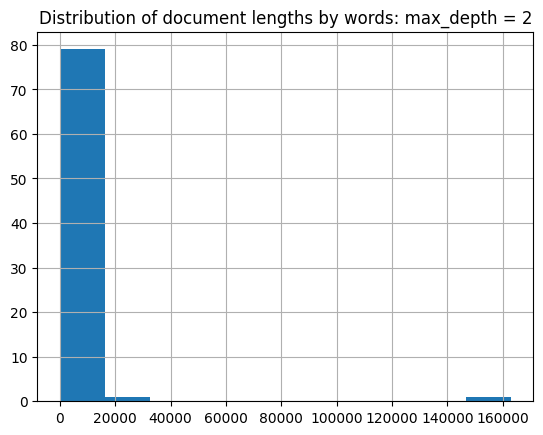

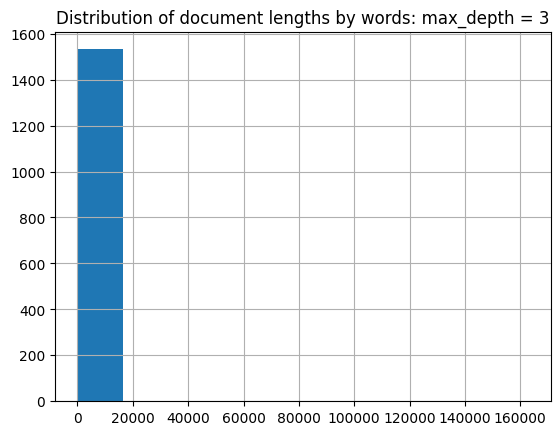

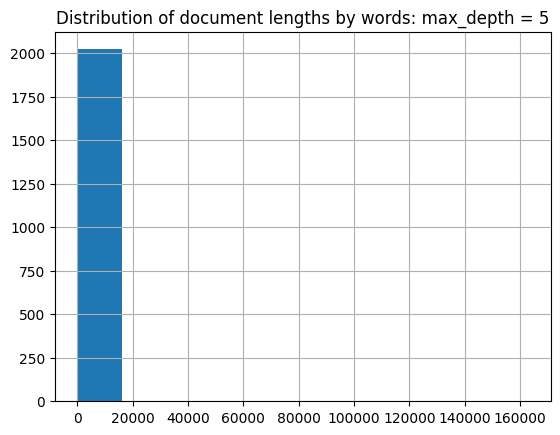

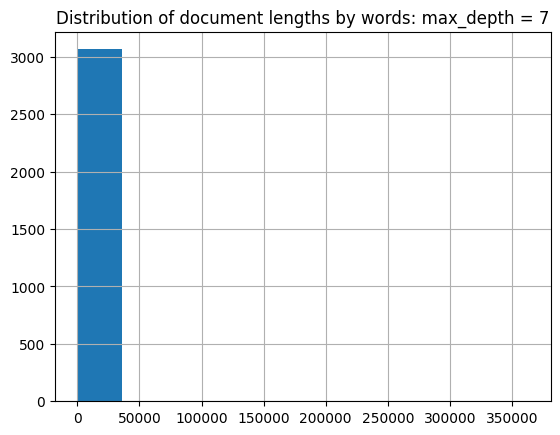

In [ ]:
titles = ["max_depth = 2", "max_depth = 3", "max_depth = 5", "max_depth = 7"]
for i, docs in enumerate(docsSets):
    lengths = [len(doc.page_content.split())for doc in docs]
    fig = pd.Series(lengths).hist()
    plt.title("Distribution of document lengths by words: " + titles[i])
    plt.show()

Seems like we have some significant outliers. Let's identify them.

In [51]:
docs = docsSets[3] #Biggest set
for doc in docs:
    if len(doc.page_content.split()) > 10000:
        print(doc.metadata["source"])

https://docs.opencv.org/4.x/d2/d75/namespacecv.html
https://docs.opencv.org/4.x/d2/de8/group__core__array.html
https://docs.opencv.org/4.x/d3/d63/classcv_1_1Mat.html
https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html
https://docs.opencv.org/4.x/df/d91/group__core__hal__intrin.html
https://docs.opencv.org/4.x/df/d1d/namespacecv_1_1cudev.html
https://docs.opencv.org/4.x/df/dfc/group__cudev.html
https://docs.opencv.org/4.x/opencv.tag
